In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
ratings2 = pd.read_pickle("./Data/small_random_selection_longform_2.pkl")

In [4]:
len(ratings), len(ratings2)

(555154, 555847)

In [5]:
ratings = pd.concat([ratings, ratings2])

In [6]:
ratings.shape

(1111001, 3)

In [7]:
ratings[ratings.duplicated(keep='first')].index

Int64Index([  4294,   6534,   6638,   7423,   7683,   7752,   9272,  11111,
             11782,  12377,
            ...
            686342, 686352, 686356, 686360, 686361, 686370, 686404, 686407,
            686408, 686411],
           dtype='int64', length=104464)

In [8]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

In [9]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(44012, 37296)

In [ ]:
# user_enc2 = LabelEncoder()
# ratings2['user'] = user_enc2.fit_transform(ratings2['user_id'].values)
# n_users2 = ratings2['user'].nunique()

# item_enc2 = LabelEncoder()
# ratings2['movie'] = item_enc2.fit_transform(ratings2['movie_id'].values)
# n_movies2 = ratings2['movie'].nunique()

# nmovie_id2 = ratings2.movie_id.nunique()
# nuser_id2 = ratings2.user_id.nunique()

# n_users2, n_movies2

In [10]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [11]:
len(X_train)

650510

In [ ]:
# l2_1 = keras.regularizers.l2(.1)
# l2_01 = 'l2'
# l2_001 = keras.regularizers.l2(.001)

In [12]:
# HP_NUM_UNITS = [32, 128]
# HP_DROPOUT = [.3, .4]
HP_LEARNING_RATE = [.01, .1]
# HP_REGULARIZER = ['l2']
# HP_EMBEDDING = [15]

In [19]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    x = keras.layers.Dense(128, 
                           activation='relu', 
                           kernel_regularizer='l2')(conc_layer)
    
    dropout = x = keras.layers.Dropout(rate=.3, seed=42)(x)
    
    dense2 = x = keras.layers.Dense(32, 
                           activation='relu', 
                           kernel_regularizer='l2')(x)
    
    dropout2 = x = keras.layers.Dropout(rate=.4, seed=42)(x)
    
    x_out = x = keras.layers.Dense(1, 
                                   activation='relu',
                                  kernel_regularizer='l2')(x)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

#     print(hist.history['val_mean_squared_error'])
    return hist, model

In [20]:
run_history = {}
models = []

session_num = 0


for learning_rate in HP_LEARNING_RATE:

    hparams = {
    'HP_LEARNING_RATE': learning_rate,
    }

    run_name = "run-{}".format(session_num)
    print("----Starting trial: {}".format(run_name))
    print(hparams)

    output, model = train_test_model(hparams,)
    run_history[run_name] = {
        'params': hparams,
        'output': output,
    }
    models.append(model)
    session_num += 1

----Starting trial: run-0
{'HP_LEARNING_RATE': 0.01}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 16.4816 - root_mean_squared_error: 3.9330 - val_loss: 15.7256 - val_root_mean_squared_error: 3.8529
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 15.7213 - root_mean_squared_error: 3.8524 - val_loss: 14.7955 - val_root_mean_squared_error: 3.7436
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 14.7866 - root_mean_squared_error: 3.7424 - val_loss: 13.4727 - val_root_mean_squared_error: 3.5734
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 13.4678 - root_mean_squared_error: 3.5727 - val_loss: 11.6110 - val_root_mean_squared_error: 3.3112
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 11.6240 - root_mean_squared_error: 3.3132 - val_loss: 9.1498 - val_root_mean_squared_error: 2.9230
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 9.2118 - root_mean_squared_e

Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 1.6308 - root_mean_squared_error: 1.1659 - val_loss: 1.1672 - val_root_mean_squared_error: 0.9488
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 1.6339 - root_mean_squared_error: 1.1692 - val_loss: 1.1767 - val_root_mean_squared_error: 0.9559
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 1.6348 - root_mean_squared_error: 1.1713 - val_loss: 1.1684 - val_root_mean_squared_error: 0.9532
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 1.6253 - root_mean_squared_error: 1.1685 - val_loss: 1.1452 - val_root_mean_squared_error: 0.9422
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 1.6058 - root_mean_squared_error: 1.1611 - val_loss: 1.1145 - val_root_mean_squared_error: 0.9267
Epoch 54/100
1/1 [==============================] - 1s 1s/step - loss: 1.5926 - root_mean_squared_error: 1.1562 - val_loss: 1.0849 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 1.4169 - root_mean_squared_error: 1.1246 - val_loss: 0.9654 - val_root_mean_squared_error: 0.9027
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 1.4131 - root_mean_squared_error: 1.1236 - val_loss: 0.9631 - val_root_mean_squared_error: 0.9023
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 1.4072 - root_mean_squared_error: 1.1217 - val_loss: 0.9617 - val_root_mean_squared_error: 0.9024
Epoch 100/100
1/1 [==============================] - 1s 1s/step - loss: 1.4067 - root_mean_squared_error: 1.1222 - val_loss: 0.9611 - val_root_mean_squared_error: 0.9031
----Starting trial: run-1
{'HP_LEARNING_RATE': 0.1}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 16.4601 - root_mean_squared_error: 3.9290 - val_loss: 2.7736 - val_root_mean_squared_error: 1.4204
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 4.0828 - root_mean_squared_error: 1.8239 - va

1/1 [==============================] - 1s 1s/step - loss: 2.1551 - root_mean_squared_error: 1.1023 - val_loss: 1.9209 - val_root_mean_squared_error: 0.9982
Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 2.1523 - root_mean_squared_error: 1.1081 - val_loss: 1.8463 - val_root_mean_squared_error: 0.9694
Epoch 47/100
1/1 [==============================] - 1s 1s/step - loss: 2.0926 - root_mean_squared_error: 1.0890 - val_loss: 1.7566 - val_root_mean_squared_error: 0.9320
Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 2.0601 - root_mean_squared_error: 1.0826 - val_loss: 1.7175 - val_root_mean_squared_error: 0.9202
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 2.0484 - root_mean_squared_error: 1.0852 - val_loss: 1.7030 - val_root_mean_squared_error: 0.9204
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 2.0150 - root_mean_squared_error: 1.0767 - val_loss: 1.7191 - val_root_mean_squared_error: 0.9359

1/1 [==============================] - 1s 1s/step - loss: 1.1810 - root_mean_squared_error: 0.8728 - val_loss: 1.2341 - val_root_mean_squared_error: 0.9064
Epoch 94/100
1/1 [==============================] - 1s 1s/step - loss: 1.1678 - root_mean_squared_error: 0.8691 - val_loss: 1.2317 - val_root_mean_squared_error: 0.9086
Epoch 95/100
1/1 [==============================] - 1s 1s/step - loss: 1.1565 - root_mean_squared_error: 0.8663 - val_loss: 1.2235 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 1s 1s/step - loss: 1.1454 - root_mean_squared_error: 0.8638 - val_loss: 1.2130 - val_root_mean_squared_error: 0.9059
Epoch 97/100
1/1 [==============================] - 1s 1s/step - loss: 1.1356 - root_mean_squared_error: 0.8622 - val_loss: 1.2070 - val_root_mean_squared_error: 0.9061
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 1.1255 - root_mean_squared_error: 0.8600 - val_loss: 1.2041 - val_root_mean_squared_error: 0.9078

In [40]:
model.save('saved_model/copy11/model.h5')

In [15]:
import matplotlib.pyplot as plt

In [21]:
len(run_history.keys())

2

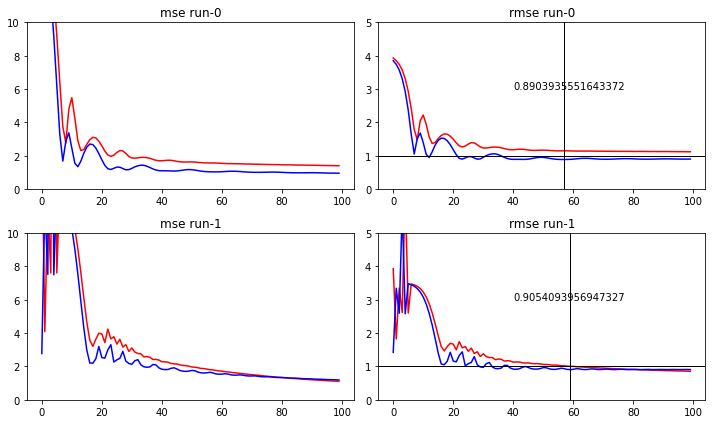

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    axs[n,1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                     color='k', lw=1)
    axs[n,1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                        xy=(40,3),)
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [23]:
print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
# print(run_history['run-3'])
# print(run_history['run-6'])

{'params': {'HP_LEARNING_RATE': 0.01}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7faec98d0310>}
{'params': {'HP_LEARNING_RATE': 0.1}, 'output': <tensorflow.python.keras.callbacks.History object at 0x7fae704c9940>}


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

colors = ['red', 'blue', 'green']
for n, key in enumerate(['run-0', 'run-3', 'run-6']):
    
    ax.plot(run_history[key]['output'].history['val_root_mean_squared_error'], color=colors[n], alpha=.8, lw=2)

ax.set_ylim(0,5)
plt.show()

In [28]:
ratings.groupby('user_id').count().sort_values(by='movie_id',ascending=False).head()

,movie_id,rating_score,user,movie
user_id,,,,
44117354,111,111,111,111
70183010,106,106,106,106
25219708,103,103,103,103
30484208,102,102,102,102
69239795,101,101,101,101


In [29]:
user_id = 44117354
ratings[ratings.user_id==user_id]

,movie_id,rating_score,user_id,user,movie
3675,830,4,44117354,19690,759
9918,31747,3,44117354,19690,13001
16199,133823,2,44117354,19690,30304
44079,26024,2,44117354,19690,9692
59731,93537,5,44117354,19690,23232
...,...,...,...,...,...
578048,45023,5,44117354,19690,18491
622495,27447,4,44117354,19690,10569
634079,147,3,44117354,19690,111
668979,197,1,44117354,19690,160


In [30]:
user = 19690

In [31]:
movie_array = ratings[ratings.user_id==user_id].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

In [32]:
pred = model.predict([movie_array, user])

In [38]:
list(zip(zip(pred.flatten(), ratings[ratings.user_id==user_id].rating_score.values),movie_array))

[((4.443749, 4), 759),
 ((3.0487213, 3), 13001),
 ((3.4955826, 2), 30304),
 ((4.2365317, 2), 9692),
 ((4.620772, 5), 23232),
 ((4.2911863, 5), 113),
 ((4.0627294, 5), 108),
 ((3.4778192, 3), 4704),
 ((3.7692504, 5), 2531),
 ((3.6930926, 4), 26290),
 ((3.4296114, 2), 1485),
 ((4.2770286, 4), 2103),
 ((3.4494987, 3), 10623),
 ((3.7676442, 5), 11182),
 ((4.4641213, 5), 903),
 ((3.811058, 5), 32392),
 ((3.9964552, 4), 17994),
 ((4.216799, 5), 32233),
 ((3.507463, 3), 3041),
 ((3.8077025, 3), 27185),
 ((2.762479, 4), 27443),
 ((4.434957, 5), 25895),
 ((4.169401, 2), 8461),
 ((3.0923502, 2), 3107),
 ((3.6240742, 4), 4452),
 ((4.223429, 5), 273),
 ((3.3390841, 3), 9604),
 ((4.2326694, 5), 22203),
 ((3.0539048, 3), 35191),
 ((4.018703, 5), 11221),
 ((3.3099916, 2), 1647),
 ((3.6017835, 5), 2883),
 ((3.4528334, 3), 3043),
 ((3.611532, 4), 5636),
 ((3.4521797, 4), 30965),
 ((3.3492951, 3), 1683),
 ((4.351111, 5), 9463),
 ((3.7766812, 3), 152),
 ((4.351217, 5), 814),
 ((3.9190128, 5), 12551),
 ((

In [33]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [34]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

In [35]:
sum(val) / len(pred.flatten())

0.36036036036036034

In [25]:
import seaborn as sns

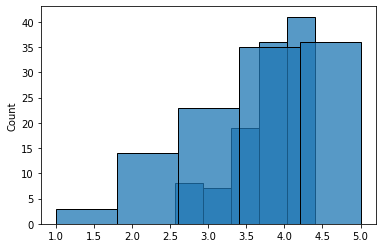

In [39]:
sns.histplot(pred.flatten(), bins=5)
sns.histplot(ratings[ratings.user_id==user_id].rating_score.values, bins=5)

plt.show()

In [47]:
np.round(pred.flatten(), 1)[0] - .5 <= 2 <= np.round(pred.flatten(), 1)[0] + .5

False

In [41]:
ratings[ratings.user_id==user_id].rating_score.values[0]

4

In [54]:
list(zip(zip(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values),val))

[((4.4, 4), True),
 ((3.0, 3), True),
 ((3.5, 2), False),
 ((4.2, 2), False),
 ((4.6, 5), True),
 ((4.3, 5), False),
 ((4.1, 5), False),
 ((3.5, 3), True),
 ((3.8, 5), False),
 ((3.7, 4), True),
 ((3.4, 2), False),
 ((4.3, 4), True),
 ((3.4, 3), True),
 ((3.8, 5), False),
 ((4.5, 5), True),
 ((3.8, 5), False),
 ((4.0, 4), True),
 ((4.2, 5), False),
 ((3.5, 3), True),
 ((3.8, 3), False),
 ((2.8, 4), False),
 ((4.4, 5), False),
 ((4.2, 2), False),
 ((3.1, 2), False),
 ((3.6, 4), True),
 ((4.2, 5), False),
 ((3.3, 3), True),
 ((4.2, 5), False),
 ((3.1, 3), True),
 ((4.0, 5), False),
 ((3.3, 2), False),
 ((3.6, 5), False),
 ((3.5, 3), True),
 ((3.6, 4), True),
 ((3.5, 4), True),
 ((3.3, 3), True),
 ((4.4, 5), False),
 ((3.8, 3), False),
 ((4.4, 5), False),
 ((3.9, 5), False),
 ((4.5, 5), True),
 ((3.6, 5), False),
 ((3.8, 5), False),
 ((3.9, 5), False),
 ((4.4, 4), True),
 ((3.1, 4), False),
 ((3.0, 1), False),
 ((3.8, 4), True),
 ((3.4, 3), True),
 ((3.9, 5), False),
 ((4.0, 5), False),
 